In [1]:
n_vars=30

indir = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_simpleUnion/" 
se_meta = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/anno_multiplex/gff_A2_black/se_cells_meta_labels.tsv"
outdir = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/mt_as_clones/variants_simpleUnion/anno_mt_af_v02/input/method_bias"
method = "bias"

conditions = None #"Input"
top_n = 30




In [2]:
import pandas as pd
from os.path import join, isdir

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from icecream import ic
from src.utils import variant_utils as vu
from glob import glob
from itertools import product
from collections import defaultdict
from tqdm.notebook import tqdm



In [25]:
import mplh.cluster_help as ch
import mplh.fig_utils as fu
from mplh.color_utils import create_color_df_v02


### Smaller params

In [4]:
don_dirs = [d for d in glob(indir + "/donor*") if isdir(d)]
don_dirs = {int(x.split("donor")[-1]):x for x in don_dirs}
don_dirs

{0: '/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_simpleUnion/donor0',
 1: '/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_simpleUnion/donor1'}

In [5]:
def load_donor(don_dir):
    vcf = pd.read_csv(join(don_dir, "cellSNP.base.vcf"), sep="\t")
    variants_meta = vcf[["#CHROM", "POS", "REF", "ALT"]]
    variants_meta.index = variants_meta.apply(lambda x: f"{x['POS']}{x['REF'][0]}>{x['ALT']}", axis=1)
    variants_meta = vu.type_of_variants(variants_meta.index)
    variants_meta["ID"] = variants_meta.index
    variants_meta.index = variants_meta.apply(lambda x: f"{x['position']}{x['alt']}", axis=1)
    af = pd.read_csv(join(don_dir, "af.tsv"), sep="\t", index_col=0)
    cov = pd.read_csv(join(don_dir, "dp.tsv"), sep="\t", index_col=0)                   
    variants = set(af.columns)
    return af, cov, variants


In [6]:
af_d = {}
cov_d = {}
for d in don_dirs: 
    curr_af, curr_cov, curr_variants = load_donor(don_dirs[d])
    if curr_af.shape[0] == 0:
        continue
    curr_cov_name = curr_cov.copy()   
    curr_cov_name.index = "COV-" + curr_cov.index
    #curr_af_cov = pd.concat([curr_af, curr_cov_name], verify_integrity=True, sort=False)
    af_d[d] = curr_af
    cov_d[d] = curr_cov

In [7]:
# append any unseen variants in different donors
allVars = [set(af_d[d].columns) for d in af_d]
allVars = allVars[0].union(*allVars)
len(allVars)

for d in af_d:
    unseen_cols = allVars - set(af_d[d].columns.values)
    print('unseen_cols')
    print(unseen_cols)
    print(len(unseen_cols))
    af_d[d].loc[:, unseen_cols] = 0
    cov_d[d].loc[:, unseen_cols] = 0

unseen_cols
{'2992A', '15497A', '11002G'}
3
unseen_cols
{'152C', '189G', '3243T', '13177A'}
4


In [8]:
labels_df = pd.read_csv(se_meta,sep="\t").set_index("ID")
print(labels_df.shape)

labels_df = labels_df[~(labels_df["donor"]=='None')]
print(labels_df.shape)
labels_df.head()

if "cluster_labels" in labels_df.columns:
    labels_df["labels"] = labels_df["cluster_labels"]
else:
    labels_df["labels"] = labels_df["seurat_clusters"]
   

(13593, 41)
(12188, 41)


In [9]:
if conditions != None and conditions != "None":
    conditions_l = conditions.split(",")
    labels_df = labels_df.loc[labels_df["condition"].isin(conditions_l)]
    print(labels_df.shape)

(5953, 42)


## Group by labels and donor 

In [10]:
all_cells=[]
for d in af_d:
    all_cells.extend(af_d[d].index.values)
all_cells = set(all_cells) #set([af_d[d].index.values for d in af_d])

print(labels_df.shape)
labels_df = labels_df[labels_df.index.isin(all_cells)]
print(labels_df.shape)

(5953, 42)
(5953, 42)


In [11]:
labels_df

,orig.ident,nCount_ATAC,nFeature_ATAC,total,duplicate,chimeric,unmapped,lowmapq,mitochondrial,passed_filters,...,nFeature_RNA,Row.names,index,raw.ID,new.index,condition,donor,donor_index,cluster_labels,labels
ID,,,,,,,,,,,,,,,,,,,,,
AAACGAAAGATATGAC-1_Input,Input,2855,2855,29954,4853,67,103,626,19521,4784,...,2505,Input_AAACGAAAGATATGAC-1,6908.0,AAACGAAAGATATGAC-1,6909.0,Input,1,3032.0,2,2
AAACGAAAGTAATGTG-1_Input,Input,6507,6507,32111,9018,96,122,1319,11232,10324,...,4861,Input_AAACGAAAGTAATGTG-1,6909.0,AAACGAAAGTAATGTG-1,6910.0,Input,1,3033.0,2,2
AAACGAAAGTAGTCGG-1_Input,Input,7528,7528,37923,12542,147,162,1705,10189,13178,...,5447,Input_AAACGAAAGTAGTCGG-1,6910.0,AAACGAAAGTAGTCGG-1,6911.0,Input,1,3034.0,0,0
AAACGAACACATTGCA-1_Input,Input,6893,6893,46206,12553,148,184,1239,16880,15202,...,5539,Input_AAACGAACACATTGCA-1,6911.0,AAACGAACACATTGCA-1,6912.0,Input,1,3035.0,10,10
AAACGAACACGCTCAG-1_Input,Input,5863,5863,38973,7584,162,150,973,19691,10413,...,4786,Input_AAACGAACACGCTCAG-1,6912.0,AAACGAACACGCTCAG-1,6913.0,Input,0,3398.0,7,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTGTGTTTCTTAC-1_Input,Input,3580,3580,17067,3257,63,80,461,8097,5109,...,2899,Input_TTTGTGTGTTTCTTAC-1,13402.0,TTTGTGTGTTTCTTAC-1,13403.0,Input,0,6999.0,0,0
TTTGTGTTCCTGAAAC-1_Input,Input,4328,4328,30427,8323,84,99,799,12146,8976,...,4144,Input_TTTGTGTTCCTGAAAC-1,13403.0,TTTGTGTTCCTGAAAC-1,13404.0,Input,0,7000.0,7,7
TTTGTGTTCGGGAAAC-1_Input,Input,8010,8010,40114,14032,169,160,1561,10102,14090,...,5890,Input_TTTGTGTTCGGGAAAC-1,13404.0,TTTGTGTTCGGGAAAC-1,13405.0,Input,0,7001.0,0,0


## Sort variants by top ANOVA

In [12]:
import scipy.stats as stats

# stats f_oneway functions takes the groups as input and returns ANOVA F and p value

def anova_mt(ser, cov_df, labels_df, min_cov=2):
    curr_cov = cov_df.loc[ser.index, ser.name]
    curr_cov = curr_cov[curr_cov>min_cov]
    ser = ser.loc[curr_cov.index]
    inds_overlap = set(list(labels_df.index.values)).intersection(set(list(ser.index.values)))
    ser = ser.loc[inds_overlap]
    curr_cov = curr_cov.loc[inds_overlap]
    curr_labels = labels_df.loc[inds_overlap]
    curr_mt_groups = [ser.loc[curr_labels["cluster_labels"]==x].values for x in curr_labels["cluster_labels"].unique()]
    #print(len(curr_mt_groups))
    if len(curr_mt_groups) == 0:
        return pd.Series({"pval":1, "fval":0})
    if len(curr_mt_groups) <= 1:
        return pd.Series({"pval":1, "fval":0})
    
    if method == "anova":
        fvalue, pvalue = stats.f_oneway(*curr_mt_groups)
    return pd.Series({"pval":pvalue, "fval":fvalue})


def bias(ser, cov_df, labels_df, min_cov=2):
    #1/[max(ncells w variant in cluster)/sum(ncells w variant)]. the 1 is to make smaller values higher
    curr_cov = cov_df.loc[ser.index, ser.name]
    curr_cov = curr_cov[curr_cov>=min_cov]
    ser = ser.loc[curr_cov.index]   
    inds_overlap = set(list(labels_df.index.values)).intersection(set(list(ser.index.values)))
    ser = ser.loc[inds_overlap]
    curr_cov = curr_cov.loc[inds_overlap]
    curr_labels = labels_df.loc[inds_overlap]
    curr_mt_groups = [ser.loc[curr_labels["cluster_labels"]==x].dropna().values for x in curr_labels["cluster_labels"].unique()]
    #print(curr_mt_groups)
    curr_mt_groups = [len(x[x>0]) for x in curr_mt_groups]
    if len(curr_mt_groups) == 0:
        return  pd.Series({"pval":1})
    
    return  pd.Series({"pval":1/(max(curr_mt_groups)/sum(curr_mt_groups))})


anova_d = {}
for d in af_d:
    if method=="anova":
        anova_out = af_d[d].apply(anova_mt, args=(cov_d[d],labels_df))
    else:
        anova_out = af_d[d].apply(bias, args=(cov_d[d],labels_df))
    anova_out
    anova_out_df = pd.DataFrame(anova_out)
    anova_out_df = anova_out_df.sort_values("pval", axis=1)
    anova_d[d] = anova_out_df
    

## Create clustermap

In [13]:
## 1. top variants by anova
## 2. min_coverage (2, 10)
## 3. Get af of cells that have one of the variants
## 4. Square root af, with a mask for coverage
## 5. sort cells by cluster (complexheatmap would be best)

In [14]:
# def plot_top(af, cov, anova_df, curr_labels_df, min_cov=2, top_n = 10):
#     curr_labels_df = curr_labels_df.loc[curr_labels_df.index.isin(af.index)]
#     mt_vars = anova_df.columns[:top_n]
#     af = af.loc[:, mt_vars]
#     cov = cov.loc[:, mt_vars]
    
#     af = af.loc[~(af==0).all(axis=1), ~(af==0).all(axis=0)]
#     cov = cov.loc[af.index, af.columns]
    
#     mask = cov.copy()
#     mask.loc[:,:] = False
#     mask[cov<min_cov] = True
    
#     # sort by curr_labels_df
#     curr_labels_df = curr_labels_df.sort_values("seurat_clusters")
#     af = af.loc[curr_labels_df.index]
#     mask = mask.loc[curr_labels_df.index]
#     g = ch.plot_cluster(af ,row_meta=curr_labels_df[["seurat_clusters", "condition"]], mask=mask, 
#                         row_clr_schemes="categorical", cmap="crest")
#     return g 

d 0
donor_vars
['13188T' '1438G' '73G' '16362C' '4769G' '8292A' '7028T' '14766T' '8860G'
 '146C' '827G' '15326G' '16126C' '64T' '263G' '2442C' '10397G' '8461T'
 '16355T' '7598A' '3847C' '750G' '10589A' '196C' '58C' '2706G' '11761T'
 '204C']


/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


d 1
donor_vars
['4917G' '1438G' '16519C' '73G' '150T' '5147A' '4769G' '930A' '7028T'
 '13368A' '14766T' '11719A' '8860G' '11812G' '10463C' '15452A' '15928A'
 '15326G' '4117C' '10559G' '16126C' '263G' '5580C' '709A' '11251G'
 '16304C' '14233G' '4216C' '16294T' '1888A' '8697A' '750G' '15607G'
 '14905A' '2706G']


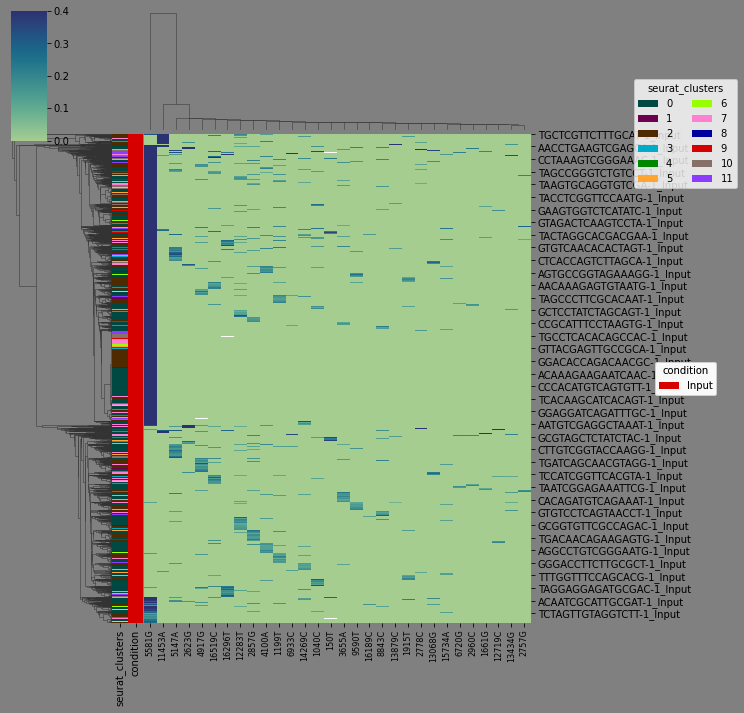

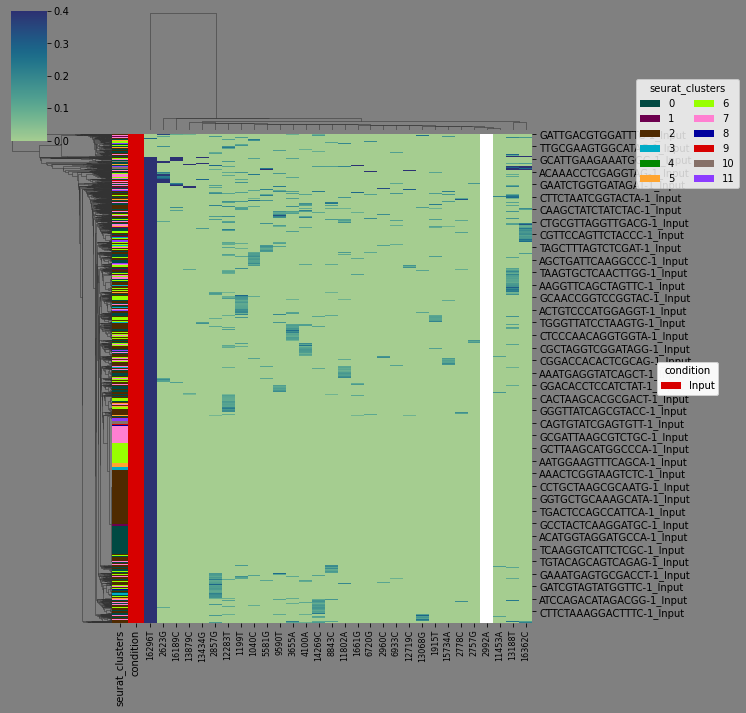

In [15]:
min_cov=10
for d in af_d:
    print('d', d)
    af = af_d[d]
    cov = cov_d[d]
    ## Remove donor vars
    donor_vars = af.loc[:,(af>0.9).sum(axis=0)>(0.9*af.shape[0])].columns.values
    print("donor_vars")
    print(donor_vars)
    
    af = af.loc[:,~(af.columns.isin(donor_vars))]
    cov = cov.loc[:,~(cov.columns.isin(donor_vars))]
    anova_df = anova_d[d][af.columns]
    curr_labels_df = labels_df.loc[labels_df.index.isin(af.index)]
    mt_vars = anova_df.columns[:top_n]
    af = af.loc[:, mt_vars]
    cov = cov.loc[:, mt_vars]
    
    af = af.loc[~(af==0).all(axis=1), ~(af==0).all(axis=0)]
    cov = cov.loc[af.index, af.columns]
    
    mask = cov.copy()
    mask.loc[:,:] = False
    mask[cov<min_cov] = True
    
    
    # sort by curr_labels_df
    curr_labels_df = curr_labels_df.loc[curr_labels_df.index.isin(af.index)]
    curr_labels_df = curr_labels_df.sort_values("seurat_clusters")
    af = af.loc[curr_labels_df.index]    
    cov = cov.loc[af.index, af.columns]
    mask = mask.loc[af.index, af.columns] 
    

    g = ch.plot_cluster(np.sqrt(af), row_meta=curr_labels_df[["seurat_clusters", "condition"]], mask=mask, 
                        row_clr_schemes="categorical", to_row_clust=True, cmap="crest",
                        vmax=0.4)
    g.fig.set_facecolor('grey')
    
    
    mask = cov<min_cov
    #af[cov<min_cov] = np.nan
    def set_mask(ser, mask):
        curr = mask.loc[ser.name]
        ser[curr] = pd.NA
        return ser

    af_mask = af.apply(set_mask, args=(mask,) , axis=1)
    curr_labels_df[["seurat_clusters", "condition"]].to_csv(join(outdir, f"minCov10_donor{d}.labels.csv"))
    np.sqrt(af_mask).to_csv(join(outdir, f"minCov10_donor{d}.af.csv"))
    
    
    fu.helper_save(join(outdir, f"minCov10_donor{d}.af.pdf"))
#colormap.set_bad("black") 


d 0
donor_vars
['13188T' '1438G' '73G' '16362C' '4769G' '8292A' '7028T' '14766T' '8860G'
 '146C' '827G' '15326G' '16126C' '64T' '263G' '2442C' '10397G' '8461T'
 '16355T' '7598A' '3847C' '750G' '10589A' '196C' '58C' '2706G' '11761T'
 '204C']
d 1
donor_vars
['4917G' '1438G' '16519C' '73G' '150T' '5147A' '4769G' '930A' '7028T'
 '13368A' '14766T' '11719A' '8860G' '11812G' '10463C' '15452A' '15928A'
 '15326G' '4117C' '10559G' '16126C' '263G' '5580C' '709A' '11251G'
 '16304C' '14233G' '4216C' '16294T' '1888A' '8697A' '750G' '15607G'
 '14905A' '2706G']


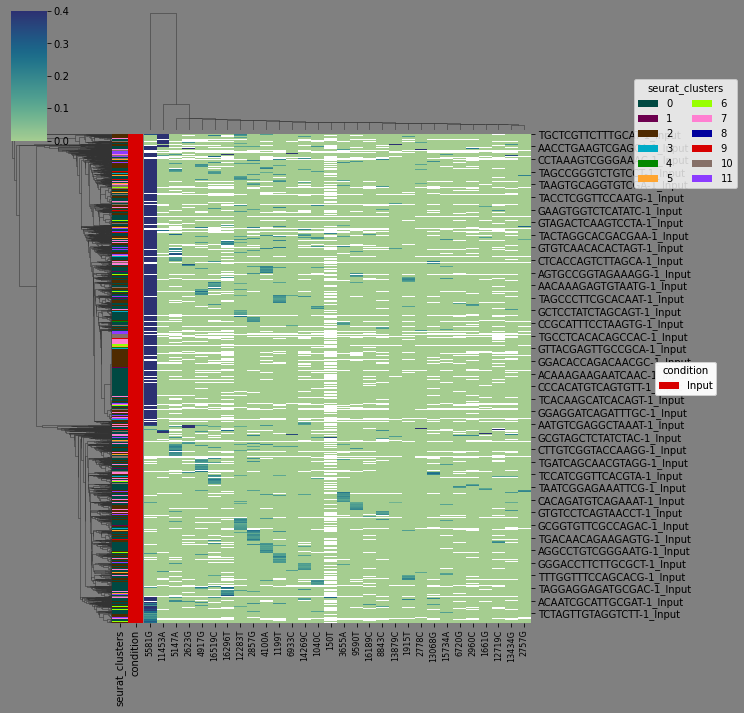

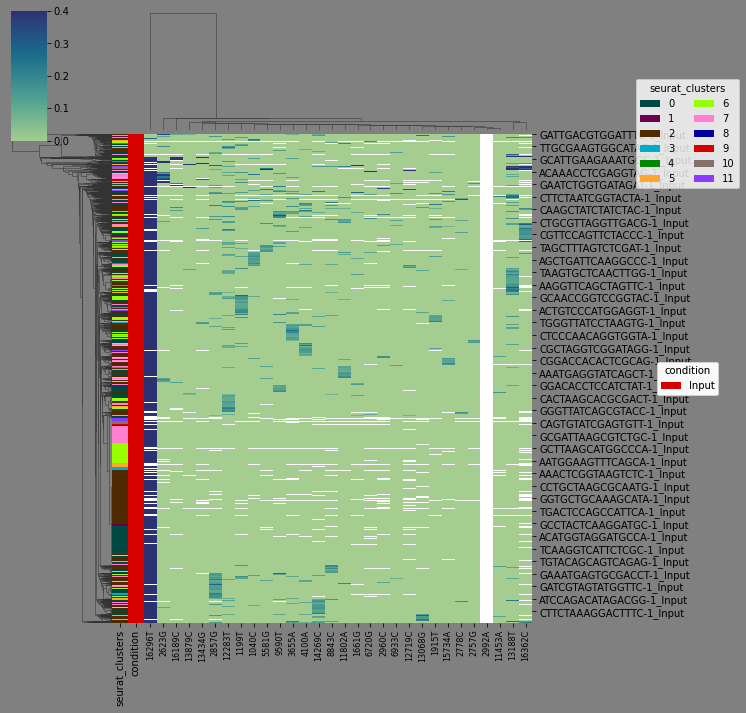

In [16]:
min_cov=50
for d in af_d:
    print('d', d)
    af = af_d[d]
    cov = cov_d[d]
    ## Remove donor vars
    donor_vars = af.loc[:,(af>0.9).sum(axis=0)>(0.9*af.shape[0])].columns.values
    print("donor_vars")
    print(donor_vars)
    
    af = af.loc[:,~(af.columns.isin(donor_vars))]
    cov = cov.loc[:,~(cov.columns.isin(donor_vars))]
    anova_df = anova_d[d][af.columns]
    curr_labels_df = labels_df.loc[labels_df.index.isin(af.index)]
    mt_vars = anova_df.columns[:top_n]
    af = af.loc[:, mt_vars]
    cov = cov.loc[:, mt_vars]
    
    af = af.loc[~(af==0).all(axis=1), ~(af==0).all(axis=0)]
    cov = cov.loc[af.index, af.columns]
    
    mask = cov.copy()
    mask.loc[:,:] = False
    mask[cov<min_cov] = True
    
    # sort by curr_labels_df
    curr_labels_df = curr_labels_df.loc[curr_labels_df.index.isin(af.index)]
    curr_labels_df = curr_labels_df.sort_values("seurat_clusters")
    af = af.loc[curr_labels_df.index]    
    mask = mask.loc[af.index, af.columns]    
    g = ch.plot_cluster(np.sqrt(af), row_meta=curr_labels_df[["seurat_clusters", "condition"]], mask=mask, 
                        row_clr_schemes="categorical", to_row_clust=True, cmap="crest",
                        vmax=0.4)
    g.fig.set_facecolor('grey')

#colormap.set_bad("black") 


### No clustering

d 0
donor_vars
['13188T' '1438G' '73G' '16362C' '4769G' '8292A' '7028T' '14766T' '8860G'
 '146C' '827G' '15326G' '16126C' '64T' '263G' '2442C' '10397G' '8461T'
 '16355T' '7598A' '3847C' '750G' '10589A' '196C' '58C' '2706G' '11761T'
 '204C']
d 1
donor_vars
['4917G' '1438G' '16519C' '73G' '150T' '5147A' '4769G' '930A' '7028T'
 '13368A' '14766T' '11719A' '8860G' '11812G' '10463C' '15452A' '15928A'
 '15326G' '4117C' '10559G' '16126C' '263G' '5580C' '709A' '11251G'
 '16304C' '14233G' '4216C' '16294T' '1888A' '8697A' '750G' '15607G'
 '14905A' '2706G']


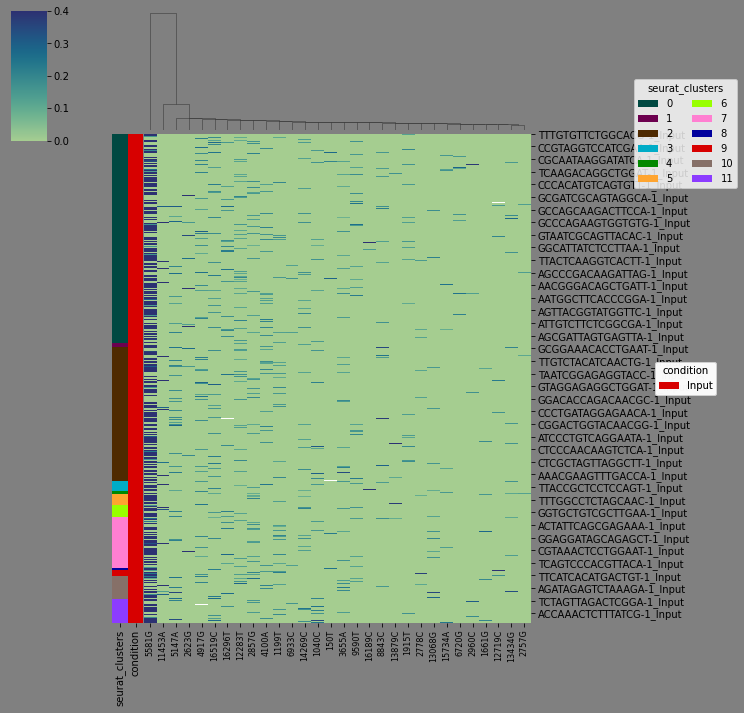

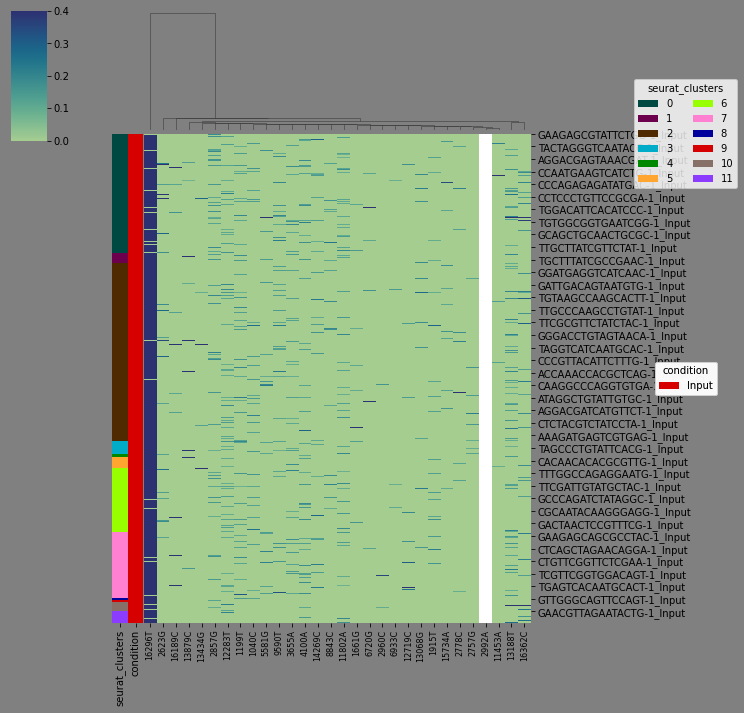

In [17]:
min_cov=10
for d in af_d:
    print('d', d)
    af = af_d[d]
    cov = cov_d[d]
    ## Remove donor vars
    donor_vars = af.loc[:,(af>0.9).sum(axis=0)>(0.9*af.shape[0])].columns.values
    print("donor_vars")
    print(donor_vars)
    
    af = af.loc[:,~(af.columns.isin(donor_vars))]
    cov = cov.loc[:,~(cov.columns.isin(donor_vars))]
    anova_df = anova_d[d][af.columns]
    curr_labels_df = labels_df.loc[labels_df.index.isin(af.index)]
    mt_vars = anova_df.columns[:top_n]
    af = af.loc[:, mt_vars]
    cov = cov.loc[:, mt_vars]
    
    af = af.loc[~(af==0).all(axis=1), ~(af==0).all(axis=0)]
    cov = cov.loc[af.index, af.columns]
    
    mask = cov.copy()
    mask.loc[:,:] = False
    mask[cov<min_cov] = True
    
    # sort by curr_labels_df
    curr_labels_df = curr_labels_df.loc[curr_labels_df.index.isin(af.index)]
    curr_labels_df = curr_labels_df.sort_values("seurat_clusters")
    af = af.loc[curr_labels_df.index]
    
    mask = mask.loc[af.index, af.columns]
    #af = af.loc[af.index.isin(curr_labels_df.index)]
    
    #af[mask] = -1
    g = ch.plot_cluster(np.sqrt(af), row_meta=curr_labels_df[["seurat_clusters", "condition"]], mask=mask, 
                        row_clr_schemes="categorical", to_row_clust=False, cmap="crest",
                        vmax=0.4)
    g.fig.set_facecolor('grey')
    fu.helper_save(join(outdir, f"minCov10_donor{d}.noCluster.af.pdf"))

In [20]:
#plot_top(af_d[0], cov_d[0], anova_d[0], labels_df, min_cov=2, top_n = 10)

In [21]:
def get_mt_mean(curr_df, af_d, labels_df):
    print(curr_df.name)
    lab, don = curr_df.name
    cells = labels_df[(labels_df["donor"]==don) & (labels_df["labels"]==lab)].index
    curr_af = af_d[int(don)]
    return curr_af.loc[cells].mean(axis=0) #curr_af.loc[curr_af.index.isin(curr_df.index)].mean(axis=0)
 
lin_mt_af = pd.DataFrame(index=labels_df.groupby(["labels", "donor"]).size().index, columns=allVars).apply(get_mt_mean, axis=1,args=(af_d, labels_df))
lin_mt_af.head()

(0, '0')
(0, '1')
(1, '0')
(1, '1')
(2, '0')
(2, '1')
(3, '0')
(3, '1')
(4, '0')
(4, '1')
(5, '0')
(5, '1')
(6, '0')
(6, '1')
(7, '0')
(7, '1')
(8, '0')
(8, '1')
(9, '0')
(9, '1')
(10, '0')
(10, '1')
(11, '0')
(11, '1')


10158C    10197A    10318C    10397G     1040C    10463C  \
labels donor                                                               
0      0      0.000317  0.000646  0.000794  0.996565  0.000726  0.002952   
       1      0.003379  0.000412  0.003528  0.004843  0.001328  0.992781   
1      0      0.000000  0.000000  0.000000  0.995863  0.000448  0.002525   
       1      0.000000  0.000000  0.000000  0.000000  0.015092  0.996404   
2      0      0.000356  0.000227  0.000636  0.995622  0.001338  0.003488   

                10559G    10589A    10626C     1082G  ...     8926T     9087A  \
labels donor                                          ...                       
0      0      0.002576  0.995739  0.000278  0.000948  ...  0.001089  0.001976   
       1      0.994609  0.003324  0.001317  0.002824  ...  0.001079  0.003324   
1      0      0.000978  0.997473  0.001297  0.003294  ...  0.000000  0.003177   
       1      0.996875  0.003184  0.000000  0.014230  ...  0.000606  0.002230   
2      0      0.003451  0.995779  0.000999  0.001030  ...  0.000738  0.001746   

                 9173A      930A     9590T     9750A     9823A      983T  \
labels donor                                                               
0      0      0.002103  0.001887  0.000963  0.000787  0.000809  0.001015   
       1      0.002362  0.996469  0.001339  0.001294  0.000757  0.001553   
1      0      0.001814  0.002371  0.000489  0.000758  0.001140  0.000792   
       1      0.002170  0.998274  0.001039  0.001647  0.000923  0.000961   
2      0      0.002023  0.001432  0.000884  0.000589  0.000773  0.000799   

                 9868A     9899C  
labels donor                      
0      0      0.001076  0.001443  
       1      0.001801  0.617193  
1      0      0.000000  0.002177  
       1      0.000177  0.611160  
2      0      0.000508  0.001784  

[5 rows x 199 columns]

# Sort variants by variance

In [22]:
def get_cv(x):
    return np.std(x, ddof=1)/ np.mean(x) * 100


def order_bar(af, labels, **kwargs):
    df = pd.DataFrame({"AF":af, "clust": labels}) #, columns=['AF',"clust"])
    order = labels.loc[af.sort_values(ascending=False).index] #by="AF", ascending=False)["labels"]
    #print(df)
    #sns.barplot(data=df, y="AF", x="clust", order=order, hue="clust", hue_order=hue_order)
    sns.barplot(y=af, x=labels, order=order, hue=labels, palette=color_out[2],dodge=False)#, hue_order=hue_order)
    #plt.xticks(rotation=45)
    return



/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  
/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


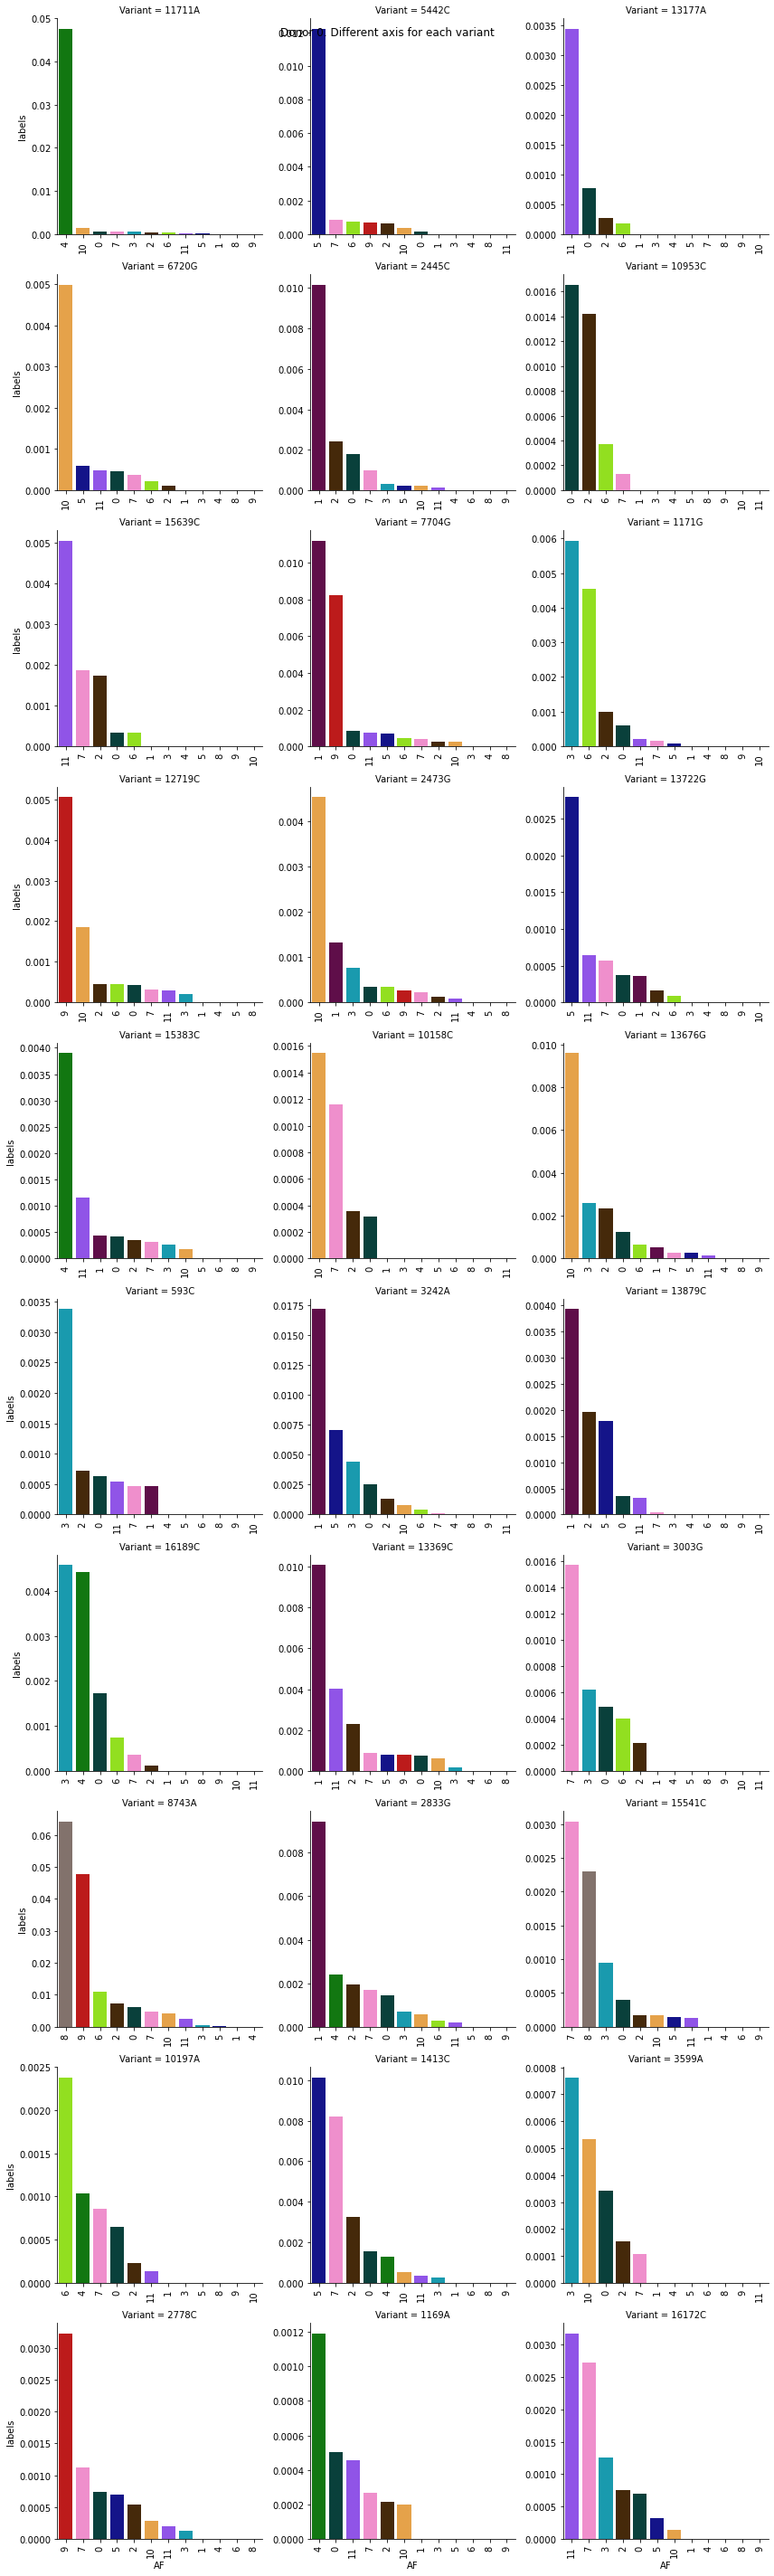

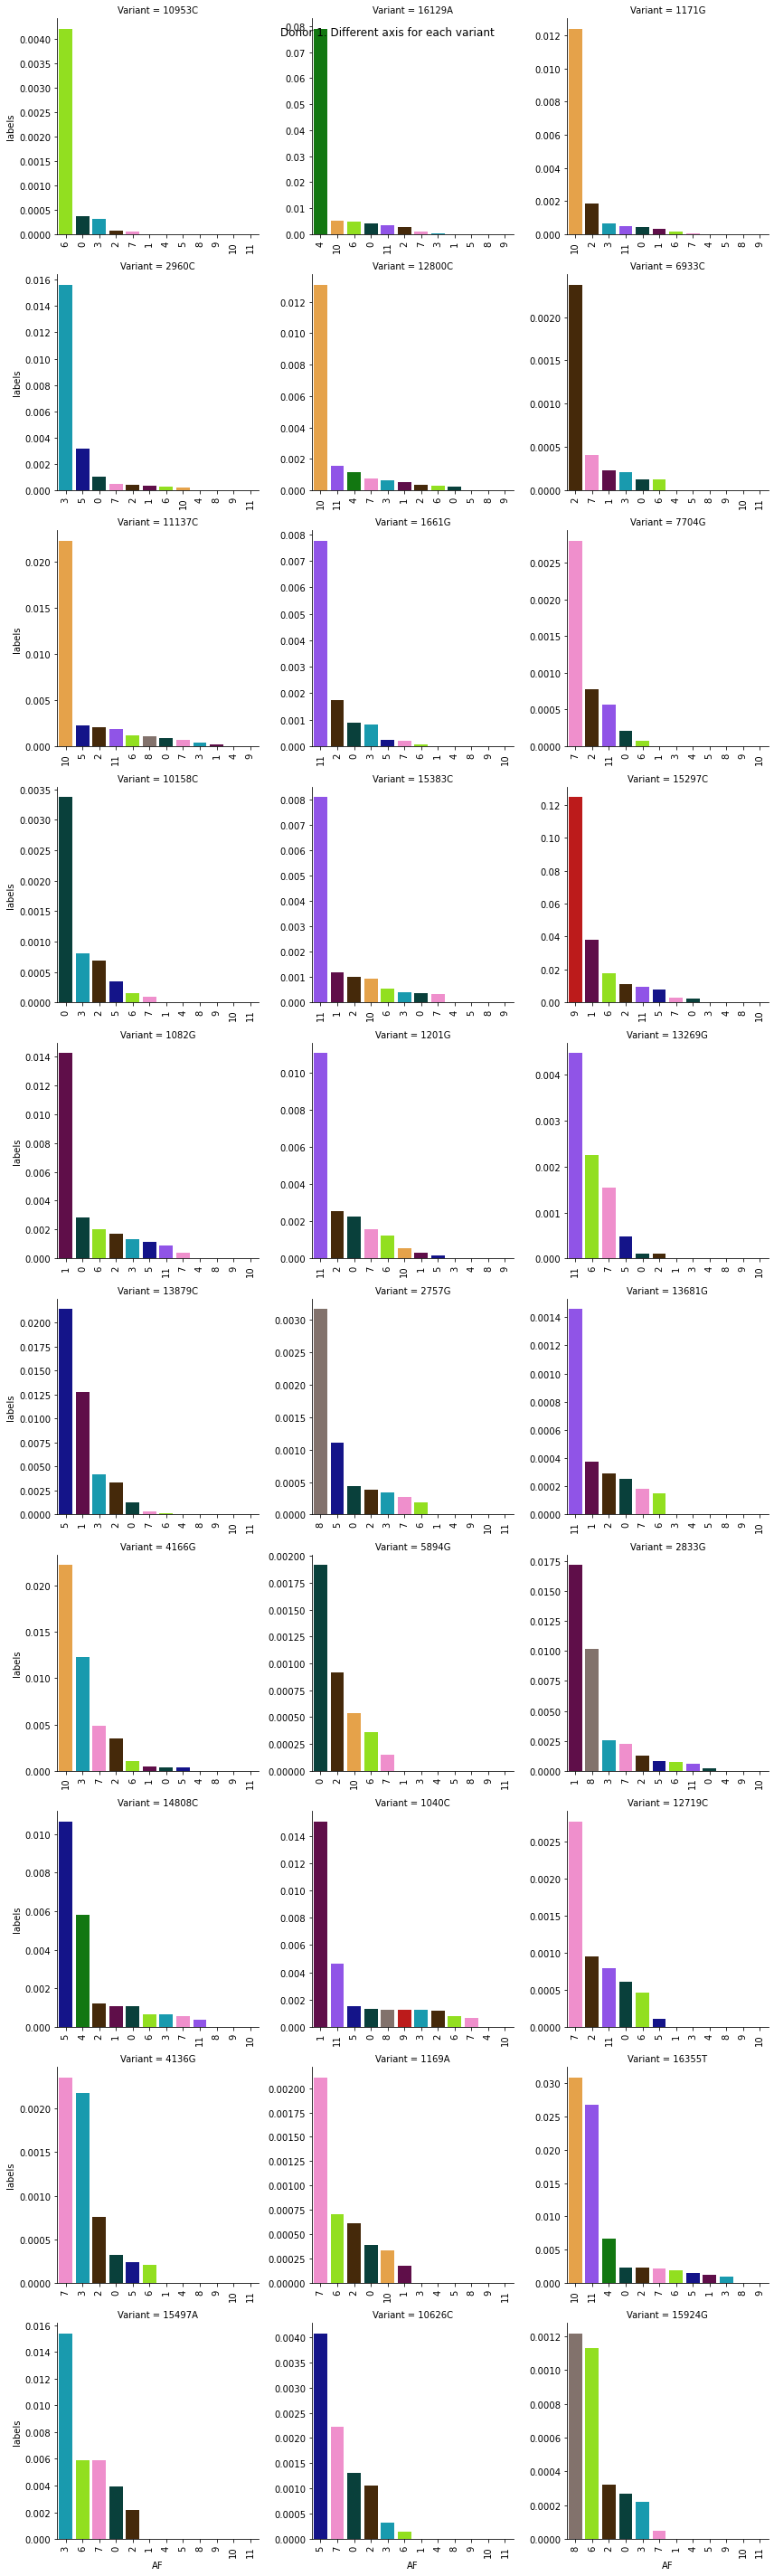

In [23]:
for curr_don, don_lin_mt_af in lin_mt_af.reset_index().groupby("donor"):
    curr_don_mt = don_lin_mt_af.set_index(["labels","donor"])
    lin_mt_cv = curr_don_mt.apply(get_cv, axis=0).sort_values(ascending=False)
    curr_don_mt = curr_don_mt.loc[:,lin_mt_cv.index]

    lin_mt_af_w = curr_don_mt.iloc[:,:n_vars].reset_index().melt(id_vars=["labels", "donor"], var_name="Variant", value_name="AF")
    #print(lin_mt_af_w)
    lin_mt_af_w["donor"] = lin_mt_af_w["donor"].astype(str)
    lin_mt_af_w["labels"] = lin_mt_af_w["labels"].astype(str)
    hue_order = lin_mt_af_w["labels"].unique()
    color_out = create_color_df_v02(lin_mt_af_w, col="labels", clr_type='categorical')
    
#    g = sns.catplot(x="labels", y="AF", col="Variant", kind='bar', data=don_af, col_wrap=4, 
 #               sharey=False, sharex=False, hue=None)
    g = sns.FacetGrid(col="Variant", data=lin_mt_af_w, col_wrap=3, sharex=False, sharey=False, 
                      hue_order=hue_order,height=4)
    g.map(order_bar, "AF", "labels")
    g.set_xticklabels(rotation=90)
    g.fig.suptitle(f"Donor {curr_don}. Different axis for each variant")
    g.fig.tight_layout()